<center>
# Автовыделение интервалов коллектора по данным ГИС
<center>

## Описание кейса

На основе седиментологического описания одного из обнажений  полигона, была построена синтетическая геологическая модель.


При ее создании для повышения степени геологического реализма полученного результата в используемую структурную поверхность был внесен разлом, который разделяет модель в пропорции 1 к 4. Таким образом, с западной стороны от разлома структурная сетка содержит 324 ячейки, а с восточной - 1056. В каждой ячейке была создана синтетическая скважина и каротажные кривые, которые рассчитывались на основе априорных знаний о физических характеристиках тех или иных литологий и ячеек, которые пересекала скважина.

<center>
# Цель работы
Основная цель работы заключается в том, чтобы используя информацию по восточной части месторождения (1056 скважин) построить модель, которая сможет прогнозировать наличие или отсутствие коллектора в интервале в зависимости от показаний каротажных кривых. Далее, используя полученную модель, необходимо предсказать наличие или отсутствие коллектора для скважин, находящихся западнее от разлома (324).


In [2]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
%matplotlib inline

In [3]:
# Загружаем данные тренировочной части
train_data = pd.DataFrame()
for file in listdir(r'data\train_test'):
    las_file = lasio.read(r'data\train_test\%s'%file).df().reset_index()
    las_file['Well'] = file[:-4]
    train_data = train_data.append(las_file, ignore_index = True)
train_data.columns = ['DEPT', 'SP', 'GR', 'DT', 'DENS', 'LITHO', 'Well']

<center>

## Описание данных

Файл с тренировочными данными содержит информацию по 1056 скважинам, находящимся восточнее разлома. Каждая скважина представлена 4 каротажными кривыми:

- **SP** (каротаж естественной поляризации)
- **GR** (гамма каротаж)
- **DT** (акустический каротаж)
- **Density** (плотностной каротаж)

В качестве кривой РИГИС выступает дискретный каротаж **LITHO**, который при значении "1" говорит о наличие коллектора, а при значении "0" о его отсутствии.

<center>
##### Статистическая оценка

В этом блоке мы поближе изучим данные со статистической точки зрения.

In [4]:
# Посмотрим, какие типы данных представлены в загруженном файле и есть ли в нем пропуски
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203099 entries, 0 to 203098
Data columns (total 7 columns):
DEPT     203099 non-null float64
SP       203099 non-null float64
GR       203099 non-null float64
DT       203099 non-null float64
DENS     203099 non-null float64
LITHO    203099 non-null float64
Well     203099 non-null object
dtypes: float64(6), object(1)
memory usage: 10.8+ MB


In [5]:
# Посмотрим статистику по данным
train_data.describe()

,DEPT,SP,GR,DT,DENS,LITHO
count,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000
mean,2514.029415,-77.407355,90.875375,307.165724,2.342216,0.323414
std,9.306925,27.588862,19.810404,11.667743,0.022138,0.467780
min,2485.100000,-125.710487,57.799000,283.392731,2.295403,0.000000
25%,2507.800000,-102.279652,71.676132,297.902679,2.324109,0.000000
50%,2514.900000,-72.802902,93.382996,303.161560,2.349329,0.000000
75%,2521.000000,-52.256079,111.070805,316.708115,2.359741,1.000000
max,2543.700000,-38.943268,116.989639,330.196503,2.390461,1.000000


Посчитаем статистические характеристики для представленных данных. Используя стандартные методы библиотеки **pandas** (фильтрация и **median**), определим медианные значения каротажей SP и GR для разностей коллектора и неколлектора.

Далее, используя метод **corr** библиотеки **pandas**, определим коэффициенты корреляции Пирсона для всех каротажных кривых.

In [6]:
SP_GR_1 = train_data.loc[train_data.LITHO == 1].loc[:,['SP', 'GR']]
SP_GR_2 = train_data.loc[train_data.LITHO == 0].loc[:,['SP', 'GR']]
print('Медиана столбцов SP & GR при наличии коллектора: SP = {}, GR = {}'.format(np.median(SP_GR_1.SP),
                                                                                 np.median(SP_GR_1.GR)))
print('Медиана столбцов SP & GR при отсутствии коллектора: SP = {}, GR = {}'.format(np.median(SP_GR_2.SP),
                                                                                    np.median(SP_GR_2.GR)))
print('Коэффициент корреляции для всех кривых:')
train_data.corr(method = 'pearson')

Медиана столбцов SP & GR при наличии коллектора: SP = -111.5234985, GR = 65.0830765
Медиана столбцов SP & GR при отсутствии коллектора: SP = -58.8327446, GR = 104.9718552
Коэффициент корреляции для всех кривых:


,DEPT,SP,GR,DT,DENS,LITHO
DEPT,1.000000,-0.326398,-0.303667,0.267074,-0.263668,0.217324
SP,-0.326398,1.000000,0.968731,-0.847788,0.836724,-0.738981
GR,-0.303667,0.968731,1.000000,-0.828245,0.814779,-0.757279
DT,0.267074,-0.847788,-0.828245,1.000000,-0.981370,0.824008
DENS,-0.263668,0.836724,0.814779,-0.981370,1.000000,-0.814091
LITHO,0.217324,-0.738981,-0.757279,0.824008,-0.814091,1.000000


<center>
##### Визуальная оценка

Ниже будет проведена визуальная оценка данных с целью найти какие-либо зависимости в данных для лучшего их понимания.

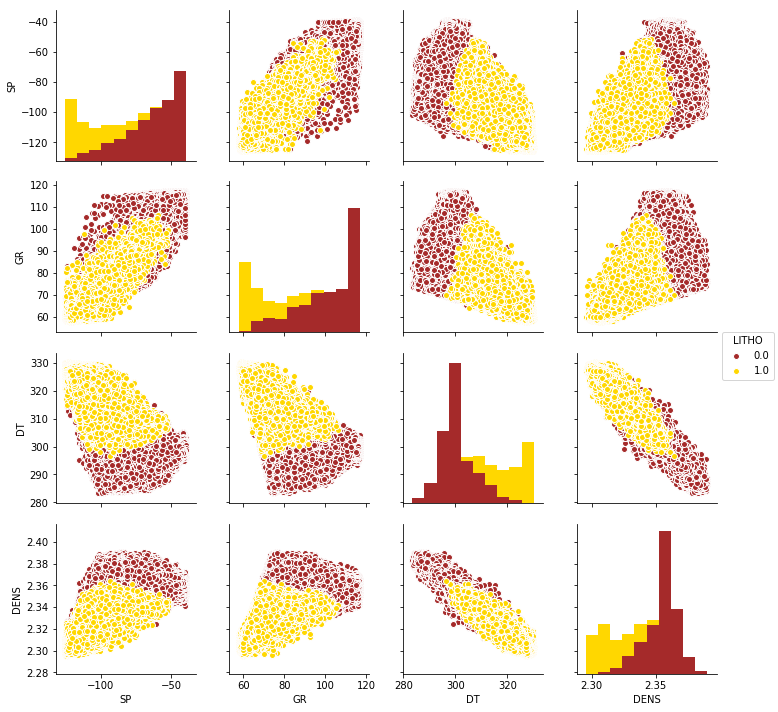

In [7]:
# Проведем визуальную оценку имеющийся информации
target_logs = [log for log in train_data.columns if log not in ['LITHO', 'Well', 'DEPT']]
sns.pairplot(train_data, vars = target_logs, hue = 'LITHO', palette = ['brown', 'gold'])

Используя библиотеку **seaborn**, построим **heatmap** ранее посчитанной корреляционной матрицы по имеющемуся набору данных.

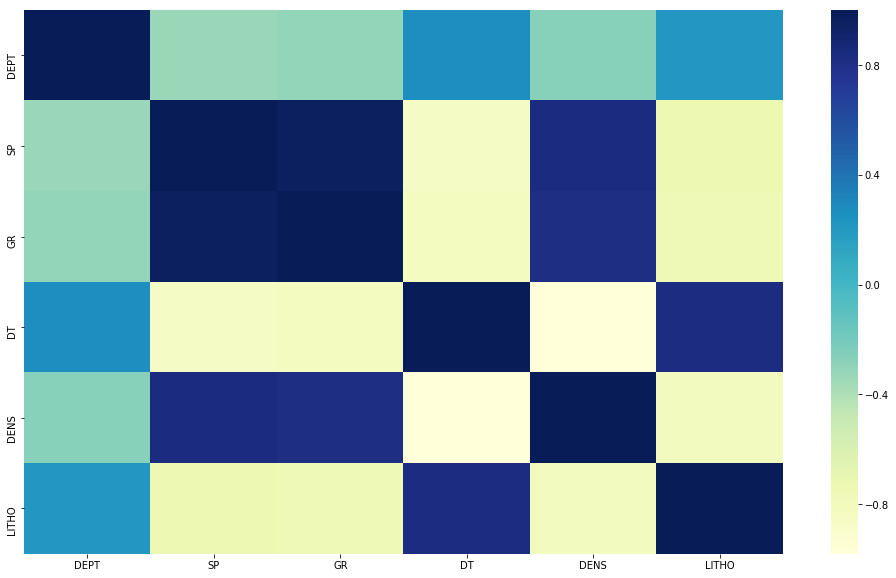

In [8]:

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10
sns.heatmap(train_data.corr(method = 'pearson'), cmap="YlGnBu")

<center>
## Генерация дополнительных признаков 
Как известно, чем больше информации мы имеем, тем более полно мы можем описать систему, порождающую то или иное распределение. Построим какие-либо новые признаки на основе уже имеющихся, которые помогли бы в построении более сложной и качественной модели.

In [52]:
train_data.head()

,DEPT,SP,GR,DT,DENS,LITHO,Well
0,2509.8,-92.088417,84.218269,314.000732,2.321674,1.0,208-901
1,2509.9,-86.453247,88.521309,311.837647,2.328126,1.0,208-901
2,2510.0,-83.557259,88.436943,311.839600,2.330478,0.0,208-901
3,2510.1,-82.992027,84.618828,313.684082,2.329336,0.0,208-901
4,2510.2,-85.293060,79.385338,316.232727,2.325939,1.0,208-901


In [53]:
# Сгенерируем множество скользящих средних к признакам с окнами 3,5 соответственно
generated_features = train_data.copy()
train_data_without = train_data.drop(['Well', 'DEPT'], axis = 1)
generated_features = train_data.drop(['Well', 'DEPT'], axis = 1)
for col in train_data_without:
    if col  != 'LITHO':
        for num in np.array([3,5]):
            key = str(col) + str(num)
            generated_features[key] = train_data[col].rolling(window = num).mean()
#заполним Nan средними значениями
generated_features = generated_features.fillna(generated_features.mean())

In [54]:
# сгенерируем степенные функции
for col in train_data_without:
    if col  != 'LITHO':
        for num in np.array([2,3]):
            key = str(col) +'exponentiation' + str(num)
            generated_features[key] = train_data[col].apply(lambda x: x**num)
generated_features.head()

,SP,GR,DT,DENS,LITHO,SP3,SP5,GR3,GR5,DT3,...,DENS3,DENS5,SPexponentiation2,SPexponentiation3,GRexponentiation2,GRexponentiation3,DTexponentiation2,DTexponentiation3,DENSexponentiation2,DENSexponentiation3
0,-92.088417,84.218269,314.000732,2.321674,1.0,-77.407332,-77.407321,90.875378,90.875389,307.165680,...,2.342216,2.342216,8480.276564,-780935.245347,7092.716884,597336.340596,98596.459948,3.095936e+07,5.390171,12.514220
1,-86.453247,88.521309,311.837647,2.328126,1.0,-77.407332,-77.407321,90.875378,90.875389,307.165680,...,2.342216,2.342216,7474.163934,-646165.741464,7836.022129,693654.935461,97242.717775,3.032394e+07,5.420169,12.618835
2,-83.557259,88.436943,311.839600,2.330478,0.0,-87.366308,-77.407321,87.058840,90.875389,312.559326,...,2.326759,2.342216,6981.815465,-583381.360285,7821.092905,691673.548208,97243.935879,3.032451e+07,5.431128,12.657124
3,-82.992027,84.618828,313.684082,2.329336,0.0,-84.334178,-77.407321,87.192360,90.875389,312.453776,...,2.329313,2.342216,6887.676595,-571622.244036,7160.346018,605900.086706,98397.703300,3.086579e+07,5.425808,12.638532
4,-85.293060,79.385338,316.232727,2.325939,1.0,-83.947449,-86.076802,84.147036,85.036137,313.918803,...,2.328585,2.327111,7274.906135,-620499.007678,6302.031858,500288.927844,100003.137626,3.162426e+07,5.409994,12.583318


In [55]:
# Рассмотрим статистику по данным
generated_features.describe()

,SP,GR,DT,DENS,LITHO,SP3,SP5,GR3,GR5,DT3,...,DENS3,DENS5,SPexponentiation2,SPexponentiation3,GRexponentiation2,GRexponentiation3,DTexponentiation2,DTexponentiation3,DENSexponentiation2,DENSexponentiation3
count,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,203099.000000,...,203099.000000,203099.000000,203099.000000,2.030990e+05,203099.000000,2.030990e+05,203099.000000,2.030990e+05,203099.000000,203099.000000
mean,-77.407355,90.875375,307.165724,2.342216,0.323414,-77.407332,-77.407321,90.875378,90.875389,307.165680,...,2.342216,2.342216,6753.040204,-6.465377e+05,8650.783885,8.556637e+05,94486.917634,2.910760e+07,5.486466,12.852778
std,27.588862,19.810404,11.667743,0.022138,0.467780,27.276403,26.808485,19.442645,18.913520,11.432723,...,0.021679,0.021005,4528.584680,6.011232e+05,3521.136150,4.843976e+05,7239.099028,3.372179e+06,0.103466,0.362700
min,-125.710487,57.799000,283.392731,2.295403,0.000000,-125.678060,-125.624760,57.856576,58.027328,283.940816,...,2.296120,2.297064,1516.578107,-1.986619e+06,3340.724378,1.930905e+05,80311.439814,2.275968e+07,5.268875,12.094191
25%,-102.279652,71.676132,297.902679,2.324109,0.000000,-101.746895,-101.177124,72.555762,73.493900,297.967127,...,2.324375,2.325225,2730.697766,-1.069960e+06,5137.467927,3.682338e+05,88746.006423,2.643767e+07,5.401484,12.553639
50%,-72.802902,93.382996,303.161560,2.349329,0.000000,-72.815552,-72.933484,93.848854,93.737663,303.426860,...,2.348863,2.348264,5300.262569,-3.858745e+05,8720.383867,8.143356e+05,91906.931522,2.786265e+07,5.519348,12.966765
75%,-52.256079,111.070805,316.708115,2.359741,1.000000,-52.752819,-53.493484,109.971535,108.581631,316.689107,...,2.359540,2.359240,10461.127142,-1.426956e+05,12336.723634,1.370250e+06,100304.029885,3.176710e+07,5.568378,13.139931
max,-38.943268,116.989639,330.196503,2.390461,1.000000,-38.971041,-38.997923,116.946009,116.866777,329.940389,...,2.389776,2.389014,15803.126642,-5.906051e+04,13686.575704,1.601188e+06,109029.730395,3.600124e+07,5.714305,13.659824


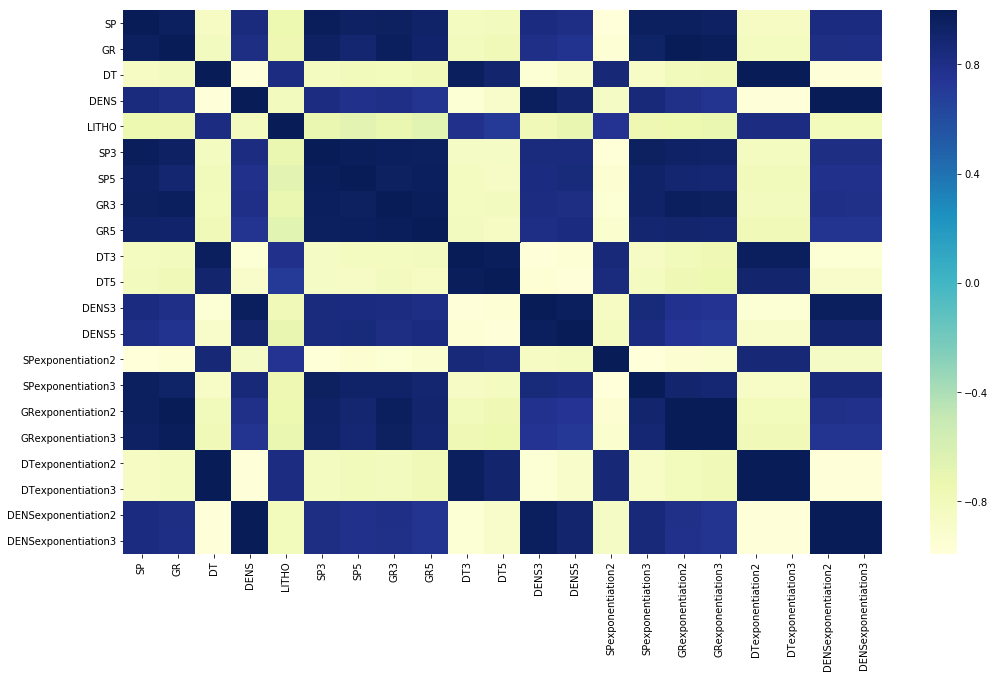

In [56]:
# Рассмотрим heatmap для корреляций признаков
sns.heatmap(generated_features.corr(method = 'pearson'), cmap="YlGnBu")

<center>
## Подготовка данных и построение базовой модели


Построим базовую модель с последующей оценкой ее качества.

In [13]:
# Разобьем данные на тренировочную и тестовую части в пропорции 0.7 и 0.3 соответственно

train_part_size = 0.7

# Случайно выберем скважины для тренировочного и тестового наборов
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(len(train_data.Well.unique())*train_part_size))
train_set = train_data.loc[train_data.Well.isin(train_wells)]
test_set = train_data.loc[train_data.Well.isin(i for i in train_data.Well.unique() if i not in train_wells)]

In [14]:
# Разобьем данные тренировочной и тестовой частей на матрицу признаков и вектор классов

Feature_train = train_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1)
Target_train = train_set['LITHO']

Feature_test = test_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1)
Target_test = test_set['LITHO']

In [15]:
# Здесь мы для предсказания будем использовать одну из самых простых моделей - Метод ближайшего соседа

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Feature_train, Target_train)
predicted_litho = clf.predict(Feature_test)

In [16]:
# Посчитаем точность полученную нашей baseline-моделью
# Считаться будут две метрики - F1 и Accuracy
base_acc = accuracy_score(Target_test, predicted_litho)
base_f1 = f1_score(Target_test, predicted_litho)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для базового кейса.'%(base_f1, base_acc))

F1 метрика равна 0.850, и доля правильных ответов составляет 0.902 для базового кейса.


<center>

# Построение моделей логистической регрессии и случайного леса

Выберем такую модель, которая показала бы более высокую точность предсказания, чем модель в ячейках выше.

In [44]:
# Гененируем тренировочную и тестовую выборки из исходного набора данных
from sklearn.model_selection import train_test_split
X = generated_features.iloc[:,5:]
y = train_data.LITHO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [48]:
# Здесь представлены нормализованные значения исходных признаков
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
#Instantiate MinMaxScaler and use it to rescale
scaler = MinMaxScaler(feature_range=(0,10))
rescaledX = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(rescaledX, y, test_size=0.3)

### Логистическая регрессия

In [49]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(X_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(X_test, y_test))

# Print the confusion matrix of the logreg model

confusion_matrix(y_test, y_pred)

Accuracy of logistic regression classifier:  0.9081897259149844


array([[38538,  2827],
       [ 2767, 16798]], dtype=int64)

In [47]:
# Посчитаем точность полученную нашей baseline-моделью для ненормализованных данных
# Считаться будут две метрики - F1 и Accuracy
base_acc = accuracy_score(y_test, y_pred)
base_f1 = f1_score(y_test, y_pred)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для базового кейса.'%(base_f1, base_acc))

F1 метрика равна 0.857, и доля правильных ответов составляет 0.908 для базового кейса.


Попробуем использовать нормализованные данные

In [50]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(X_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(X_test, y_test))

# Print the confusion matrix of the logreg model

confusion_matrix(y_test, y_pred)

Accuracy of logistic regression classifier:  0.9220088626292466


array([[38975,  2297],
       [ 2455, 17203]], dtype=int64)

In [51]:
# Посчитаем точность полученную нашей baseline-моделью для нормализованных данных
# Считаться будут две метрики - F1 и Accuracy
base_acc = accuracy_score(y_test, y_pred)
base_f1 = f1_score(y_test, y_pred)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для базового кейса.'%(base_f1, base_acc))

F1 метрика равна 0.879, и доля правильных ответов составляет 0.922 для базового кейса.


Таким образом нормализованные данные справились лучше. Показав F1 = 0.88 и accuracy = 0.922

### Случайный лес

In [39]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth = 14, 
                            n_jobs=-1, oob_score=True)


#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [168]:
base_acc = accuracy_score(y_test, y_pred)
base_f1 = f1_score(y_test, y_pred)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для базового кейса.'%(base_f1, base_acc))

F1 метрика равна 0.930, и доля правильных ответов составляет 0.955 для базового кейса.


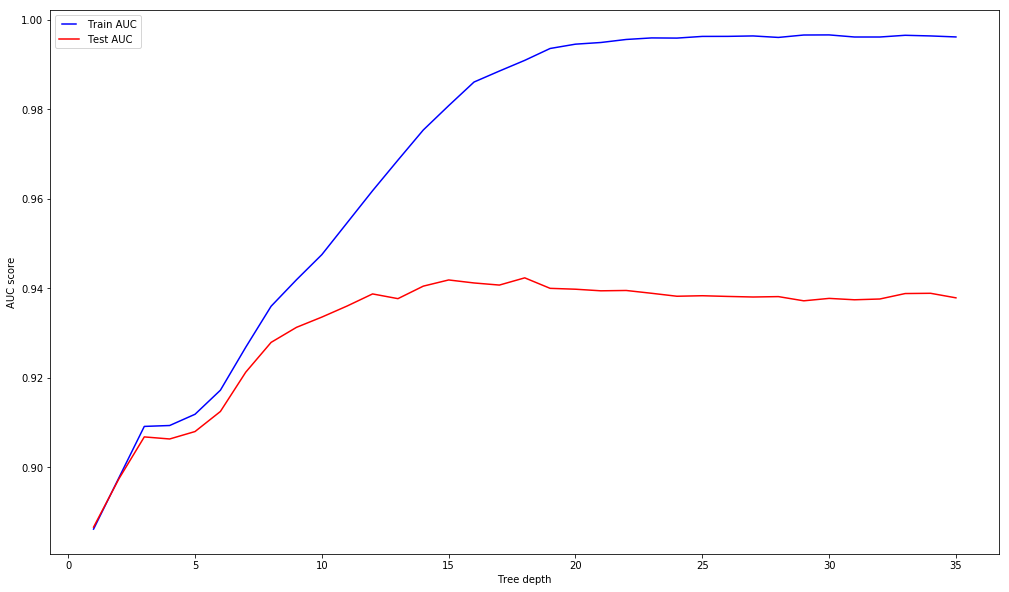

In [41]:
# Influence values of max_depth parameter on the final score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
max_depths = np.linspace(1, 35, 35, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)

    train_pred = rf.predict(X_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = rf.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

### Остановимся на модели Случайный лес
- хотя логистическая регрессия показала F1 = 0.88 и accuracy = 0.922, случайный лес классифицирует одинаково, что на нормализованных данных, что на ненормализованных. 
- Показатели модели случайного леса: F1 приблизительно 0.93 и accuracy = 0.955